In [1]:
import requests
from datetime import datetime
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

## FIMA NFIP Redacted Claims - v2 dataset, FEMA
“FIMA NFIP Redacted Claims - v2 | FEMA.gov.” 2023b. Www.fema.gov. 
    July 5, 2023. https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2.

Congress passed the National Flood Insurance Act (NFIA), 42 U.S.C. 4001 in 1968, creating the National Flood Insurance Program (NFIP) in order to reduce future flood losses through flood hazard identification, floodplain management, and providing insurance protection. The Department of Housing and Urban Development (HUD) originally administered the NFIP, and Congress subsequently transferred the NFIP to FEMA upon its creation in 1979. FEMA and insurance companies participating in FEMA's Write Your Own (WYO) program offer NFIP insurance coverage for building structures as well as for contents and personal property within the building structures to eligible and insurable properties. The WYO program began in 1983 with NFIP operating under Part B of the NFIA and allows FEMA to authorize private insurance companies to issue the Standard Flood Insurance Policy (SFIP) as FEMA's fiduciary and fiscal agent. FEMA administers NFIP by ensuring insurance applications are processed properly; determining correct premiums; renewing, reforming, and cancelling insurance policies; transferring policies from the seller of the property to the purchaser of the property in certain circumstances; and processing insurance claims.

The paid premiums of SFIPs and claims payments for damaged property are processed through the National Flood Insurance Fund (NFIF). NFIF was established by the National Flood Insurance Act of 1968 (42 U.S.C. 4001, et seq.), and is a centralized premium revenue and fee-generated fund that supports NFIP, which holds these U.S. Treasury funds.

This dataset provides details on NFIP claims transactions. It is derived from the NFIP system of record, staged in the NFIP reporting platform and redacted to protect policy holder personally identifiable information.

The Flood Insurance Claims Manual (https://nfipservices.floodsmart.gov/insurance-manuals) provides claims guidance to WYOs, vendors, adjusters, and examiners so that policyholders experience consistent and reliable service. The Manual provides processes for handling claims from the notice of loss to final payment. The NFIP has provided answers to Frequently Asked Questions (FAQs) to assist the public in understanding and navigating the data our program makes available: https://www.fema.gov/sites/default/files/documents/fema_nfip-data-faq record.

This dataset is not intended to be an official federal report, and should not be considered an official federal report.

FEMA's terms and conditions and citation requirements for datasets (API usage or file downloads) can be found on the OpenFEMA Terms and Conditions page: https://www.fema.gov/about/openfema/terms-conditions.

In [3]:
# URL of the CSV file to download
url = "https://www.fema.gov/about/reports-and-data/openfema/FimaNfipClaims.csv"

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    
    # Specify the file path where you want to save the downloaded file
    file_path = "FimaNfipClaims_all.csv"
    
    # Write the content of the response to a file
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print("File downloaded successfully.")
    
else:
    print("Failed to download file.")

File downloaded successfully.


In [5]:
# Read the full file, create a variable.
# I've been dividing my dataframes by state, but just in case I want the full thing, it's accessible.
# Given the size of these files, I usually read them with low_memory set to False.

all_nfip = pd.read_csv('FimaNfipClaims_all.csv', low_memory = False)

In [7]:
# Filter for Penn. data only, create a variable for that dataframe.
# If I were working with multiple states, I'd specify PA in the variable name.
# But this notebook is exclusive to PA, and it's easier to call the dataframe something simple like nfip.
# And just to be sure I didn't overlook something in my filter coding, I check the unique values in the state column.

nfip = all_nfip[all_nfip['state'] == 'PA']
nfip.state.unique()

array(['PA'], dtype=object)

## Exploratory Data Analysis

In [9]:
nfip.shape

(76671, 73)

In [11]:
nfip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76671 entries, 35 to 2285241
Data columns (total 73 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   agricultureStructureIndicator               76671 non-null  int64  
 1   asOfDate                                    76671 non-null  object 
 2   basementEnclosureCrawlspaceType             50153 non-null  float64
 3   policyCount                                 76671 non-null  int64  
 4   crsClassificationCode                       1132 non-null   float64
 5   dateOfLoss                                  76671 non-null  object 
 6   elevatedBuildingIndicator                   76671 non-null  int64  
 7   elevationCertificateIndicator               17162 non-null  object 
 8   elevationDifference                         3825 non-null   float64
 9   baseFloodElevation                          4265 non-null   float64
 10  ratedFloodZo

In [13]:
nfip.describe()

,agricultureStructureIndicator,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,elevatedBuildingIndicator,elevationDifference,baseFloodElevation,houseWorship,locationOfContents,lowestAdjacentGrade,...,stateOwnedIndicator,waterDepth,buildingDescriptionCode,rentalPropertyIndicator,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude
count,76671.000000,50153.000000,76671.000000,1132.000000,76671.000000,3825.000000,4265.000000,76671.000000,47483.000000,3290.000000,...,76671.000000,67471.000000,25363.000000,76671.000000,75270.000000,75414.000000,6.953600e+04,6.953600e+04,75541.000000,75541.000000
mean,0.000143,1.670927,1.049145,7.696996,0.098029,-1.457516,425.773388,0.000196,2.708633,342.176109,...,0.000639,5.077144,1.515712,0.006795,17611.710376,42061.528788,4.205554e+10,4.205554e+11,40.579704,-76.916145
std,0.011977,0.693655,1.901201,1.171829,0.297356,27.411532,707.417783,0.013986,1.110734,676.016119,...,0.025272,17.355559,1.828617,0.082153,1436.894686,38.664339,4.401506e+08,4.401506e+09,0.561647,1.682336
min,0.000000,0.000000,1.000000,6.000000,0.000000,-859.000000,-15.000000,0.000000,1.000000,-7.300000,...,0.000000,-144.000000,1.000000,0.000000,2568.000000,42001.000000,5.029950e+09,5.029950e+10,18.300000,-120.500000
25%,0.000000,1.000000,1.000000,7.000000,0.000000,-5.000000,79.600000,0.000000,2.000000,22.625000,...,0.000000,0.000000,1.000000,0.000000,16925.000000,42029.000000,4.202930e+10,4.202930e+11,40.200000,-77.700000
50%,0.000000,2.000000,1.000000,8.000000,0.000000,0.000000,322.300000,0.000000,2.000000,198.200000,...,0.000000,0.000000,1.000000,0.000000,17801.000000,42067.000000,4.206396e+10,4.206396e+11,40.400000,-76.600000
75%,0.000000,2.000000,1.000000,8.000000,0.000000,3.000000,565.000000,0.000000,3.000000,494.075000,...,0.000000,3.000000,1.000000,0.000000,18930.000000,42091.000000,4.209120e+10,4.209120e+11,41.000000,-75.500000
max,1.000000,4.000000,236.000000,10.000000,1.000000,792.000000,9990.000000,1.000000,7.000000,9992.000000,...,1.000000,770.000000,12.000000,1.000000,73160.000000,42133.000000,7.203716e+10,7.203716e+11,45.000000,-65.600000


In [15]:
# reportedCity jumps out as a column I may not want
# Let's check it out

nfip.reportedCity.unique()

array(['Currently Unavailable'], dtype=object)

In [17]:
# First dropping of columns. These are just the ones I can see right away I won't need.

nfip = nfip.drop(['reportedCity', 'censusTract', 'censusBlockGroupFips', 'state'], axis = 1)

In [19]:
# More EDA, checking out the years this data covers

years = nfip.yearOfLoss.unique()
years_list = years.tolist()
np.sort(years_list)

array([1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988,
       1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024])

In [21]:
# CamelCase in column names drives me nuts in Tableau, so I like to change NFIP column names to snake case.
# This function has come in super handy.

def camel_to_snake(name):
    return re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()

nfip.columns = [camel_to_snake(col) for col in nfip.columns]

nfip.columns

Index(['agriculture_structure_indicator', 'as_of_date',
       'basement_enclosure_crawlspace_type', 'policy_count',
       'crs_classification_code', 'date_of_loss',
       'elevated_building_indicator', 'elevation_certificate_indicator',
       'elevation_difference', 'base_flood_elevation', 'rated_flood_zone',
       'house_worship', 'location_of_contents', 'lowest_adjacent_grade',
       'lowest_floor_elevation', 'number_of_floors_in_the_insured_building',
       'non_profit_indicator', 'obstruction_type', 'occupancy_type',
       'original_construction_date', 'original_n_b_date',
       'amount_paid_on_building_claim', 'amount_paid_on_contents_claim',
       'amount_paid_on_increased_cost_of_compliance_claim',
       'post_f_i_r_m_construction_indicator', 'rate_method',
       'small_business_indicator_building',
       'total_building_insurance_coverage',
       'total_contents_insurance_coverage', 'year_of_loss',
       'primary_residence_indicator', 'building_damage_amount',
  

In [23]:
# A couple columns names need tidying

nfip = nfip.rename(columns = {'post_f_i_r_m_construction_indicator': 'post_firm_construction_indicator', 'original_n_b_date': 'original_nb_date'})
nfip.columns

Index(['agriculture_structure_indicator', 'as_of_date',
       'basement_enclosure_crawlspace_type', 'policy_count',
       'crs_classification_code', 'date_of_loss',
       'elevated_building_indicator', 'elevation_certificate_indicator',
       'elevation_difference', 'base_flood_elevation', 'rated_flood_zone',
       'house_worship', 'location_of_contents', 'lowest_adjacent_grade',
       'lowest_floor_elevation', 'number_of_floors_in_the_insured_building',
       'non_profit_indicator', 'obstruction_type', 'occupancy_type',
       'original_construction_date', 'original_nb_date',
       'amount_paid_on_building_claim', 'amount_paid_on_contents_claim',
       'amount_paid_on_increased_cost_of_compliance_claim',
       'post_firm_construction_indicator', 'rate_method',
       'small_business_indicator_building',
       'total_building_insurance_coverage',
       'total_contents_insurance_coverage', 'year_of_loss',
       'primary_residence_indicator', 'building_damage_amount',
      

In [25]:
# A lot of my analysis will depend on geo-locators. FIPS and zip codes are always important to clean.

nfip.county_code.unique()

array([42109., 42017., 42013., 42071., 42003., 42015., 42129., 42001.,
          nan, 42005., 42007., 42009., 42011., 42095., 42019., 42021.,
       42023., 42025., 42027., 42029., 42031., 42033., 42035., 42081.,
       42037., 42097., 42039., 42041., 42079., 42043., 42133., 42045.,
       42047., 42049., 42051., 42055., 42059., 42061., 42063., 42065.,
       42067., 42069., 42073., 42075., 42077., 42113., 42083., 42085.,
       42087., 42089., 42091., 42093., 42099., 42101., 42105., 42107.,
       42111., 42115., 42117., 42119., 42121., 42123., 42125., 42127.,
       42131., 42053., 42057., 42103.])

In [27]:
nfip.reported_zip_code.unique()

array([17870., 19007., 16602., ..., 15547., 15633., 18464.])

In [29]:
nfip['county_code'] = nfip['county_code'].astype(str)

In [31]:
nfip['reported_zip_code'] = nfip['reported_zip_code'].astype(str)

In [33]:
# Now they're strings and not floats, I gotta get rid of that ".0" at the end

nfip['reported_zip_code'] = nfip['reported_zip_code'].str[:-2] 

In [35]:
nfip['county_code'] = nfip['county_code'].str[:-2] 

In [37]:
# NFIP data is split into building and contents claims. For birds-eye-level analysis, I find it helpful to combine them.
# So I set up four new columns for that, plus one to add the county name, which is helpful during EDA.

nfip['damage'] = ''
nfip['net_payment'] = ''
nfip['total_payment'] = ''
nfip['coverage'] = ''
nfip['county_name'] = ''

In [39]:
# Concatenate building and contents damage

nfip['damage'] = nfip['building_damage_amount'].fillna(0) + nfip['contents_damage_amount'].fillna(0)

In [41]:
# Concatenate building and contents net payment

nfip['net_payment'] = nfip['net_building_payment_amount'].fillna(0) + nfip['net_contents_payment_amount'].fillna(0)

In [43]:
# Concatenate building and contents total payment

nfip['total_payment'] = nfip['amount_paid_on_building_claim'].fillna(0) + nfip['amount_paid_on_contents_claim'].fillna(0) + nfip['amount_paid_on_increased_cost_of_compliance_claim'].fillna(0)

In [45]:
# Concatenate building and contents total policy coverage

nfip['coverage'] = nfip['total_building_insurance_coverage'].fillna(0) + nfip['total_contents_insurance_coverage'].fillna(0)

In [47]:
# Create a dictionary of PA county names, in anticipating of filling the new county_name column

pa_counties = {
    '42001': 'Adams',
    '42003': 'Allegheny',
    '42005': 'Armstrong',
    '42007': 'Beaver',
    '42009': 'Bedford',
    '42011': 'Berks',
    '42013': 'Blair',
    '42015': 'Bradford',
    '42017': 'Bucks',
    '42019': 'Butler',
    '42021': 'Cambria',
    '42023': 'Cameron',
    '42025': 'Carbon',
    '42027': 'Centre',
    '42029': 'Chester',
    '42031': 'Clarion',
    '42033': 'Clearfield',
    '42035': 'Clinton',
    '42037': 'Columbia',
    '42039': 'Crawford',
    '42041': 'Cumberland',
    '42043': 'Dauphin',
    '42045': 'Delaware',
    '42047': 'Elk',
    '42049': 'Erie',
    '42051': 'Fayette',
    '42053': 'Forest',
    '42055': 'Franklin',
    '42057': 'Fulton',
    '42059': 'Greene',
    '42061': 'Huntingdon',
    '42063': 'Indiana',
    '42065': 'Jefferson',
    '42067': 'Juniata',
    '42069': 'Lackawanna',
    '42071': 'Lancaster',
    '42073': 'Lawrence',
    '42075': 'Lebanon',
    '42077': 'Lehigh',
    '42079': 'Luzerne',
    '42081': 'Lycoming',
    '42083': 'McKean',
    '42085': 'Mercer',
    '42087': 'Mifflin',
    '42089': 'Monroe',
    '42091': 'Montgomery',
    '42093': 'Montour',
    '42095': 'Northampton',
    '42097': 'Northumberland',
    '42099': 'Perry',
    '42101': 'Philadelphia',
    '42103': 'Pike',
    '42105': 'Potter',
    '42107': 'Schuylkill',
    '42109': 'Snyder',
    '42111': 'Somerset',
    '42113': 'Sullivan',
    '42115': 'Susquehanna',
    '42117': 'Tioga',
    '42119': 'Union',
    '42121': 'Venango',
    '42123': 'Warren',
    '42125': 'Washington',
    '42127': 'Wayne',
    '42129': 'Westmoreland',
    '42131': 'Wyoming',
    '42133': 'York'
}

In [49]:
# Fill the county_name column and check what the dataframe looks like now

nfip['county_name'] = nfip.apply(
    lambda row: pa_counties.get(row['county_code'], row['county_name']),
    axis = 1
)
nfip.head()

,agriculture_structure_indicator,as_of_date,basement_enclosure_crawlspace_type,policy_count,crs_classification_code,date_of_loss,elevated_building_indicator,elevation_certificate_indicator,elevation_difference,base_flood_elevation,...,reported_zip_code,county_code,latitude,longitude,id,damage,net_payment,total_payment,coverage,county_name
35,0,2021-07-24T13:15:12.062Z,0.0,1,NaN,2004-09-17T00:00:00.000Z,0,NaN,NaN,NaN,...,17870,42109,40.8,-76.8,8d3cd611-ca6b-4fd0-ae71-c5e852556767,12233.0,11233.28,11233.28,31700.0,Snyder
95,0,2020-01-22T16:55:53.194Z,1.0,1,NaN,2007-04-15T00:00:00.000Z,0,NaN,NaN,NaN,...,19007,42017,40.1,-74.9,f115927f-a8f4-4d7a-af49-ed93000ef678,2842.0,2341.81,2341.81,350000.0,Bucks
96,0,2020-01-22T16:55:53.194Z,2.0,1,NaN,2014-06-11T00:00:00.000Z,0,NaN,NaN,NaN,...,16602,42013,40.5,-78.4,2d054cf7-9513-41ec-b27b-b4973c530284,1126.0,126.27,126.27,70000.0,Blair
97,0,2020-01-22T16:55:53.194Z,2.0,1,NaN,2015-07-14T00:00:00.000Z,0,NaN,NaN,NaN,...,16602,42013,40.5,-78.4,bb486acb-ac2f-4bc8-9ae0-9cb6fc9bdf20,2024.0,1024.41,1024.41,70000.0,Blair
98,0,2020-01-22T16:55:53.194Z,2.0,1,NaN,2017-05-01T00:00:00.000Z,0,NaN,NaN,NaN,...,16602,42013,40.5,-78.4,3b990a40-135e-442c-87db-b7551eb9b443,2283.0,3244.14,3244.14,70000.0,Blair


In [51]:
# Not bad. Right away I see I want to clean up that date_of_loss column though.

nfip.date_of_loss.dtype

dtype('O')

In [53]:
nfip.date_of_loss

35         2004-09-17T00:00:00.000Z
95         2007-04-15T00:00:00.000Z
96         2014-06-11T00:00:00.000Z
97         2015-07-14T00:00:00.000Z
98         2017-05-01T00:00:00.000Z
                     ...           
2285237    2010-07-10T00:00:00.000Z
2285238    2006-06-28T00:00:00.000Z
2285239    2005-04-02T00:00:00.000Z
2285240    2001-06-17T00:00:00.000Z
2285241    2008-12-12T00:00:00.000Z
Name: date_of_loss, Length: 76671, dtype: object

In [55]:
nfip['date_of_loss'] = nfip['date_of_loss'].str[:10] 

In [57]:
nfip.date_of_loss

35         2004-09-17
95         2007-04-15
96         2014-06-11
97         2015-07-14
98         2017-05-01
              ...    
2285237    2010-07-10
2285238    2006-06-28
2285239    2005-04-02
2285240    2001-06-17
2285241    2008-12-12
Name: date_of_loss, Length: 76671, dtype: object

In [59]:
nfip['date_of_loss'] = pd.to_datetime(nfip['date_of_loss'])

In [61]:
nfip.date_of_loss

35        2004-09-17
95        2007-04-15
96        2014-06-11
97        2015-07-14
98        2017-05-01
             ...    
2285237   2010-07-10
2285238   2006-06-28
2285239   2005-04-02
2285240   2001-06-17
2285241   2008-12-12
Name: date_of_loss, Length: 76671, dtype: datetime64[ns]

In [63]:
# Another date column to clean

nfip.original_construction_date

35         1950-05-13T00:00:00.000Z
95         1970-01-01T00:00:00.000Z
96         1974-07-01T00:00:00.000Z
97         1974-07-01T00:00:00.000Z
98         1974-07-01T00:00:00.000Z
                     ...           
2285237    1986-01-01T00:00:00.000Z
2285238    1953-01-01T00:00:00.000Z
2285239    1953-01-01T00:00:00.000Z
2285240    1950-07-01T00:00:00.000Z
2285241    2002-01-01T00:00:00.000Z
Name: original_construction_date, Length: 76671, dtype: object

In [65]:
nfip['original_construction_date'] = nfip['original_construction_date'].str[:10] 

In [67]:
nfip.original_construction_date

35         1950-05-13
95         1970-01-01
96         1974-07-01
97         1974-07-01
98         1974-07-01
              ...    
2285237    1986-01-01
2285238    1953-01-01
2285239    1953-01-01
2285240    1950-07-01
2285241    2002-01-01
Name: original_construction_date, Length: 76671, dtype: object

In [69]:
# Get ready to reorder my columns, making them easier for me to read and analyze.
# First step is creating an enumerated dictionary of column names. (I love enumerating.)

cols = list(nfip.columns)
col_dict = {i: col for i, col in enumerate(cols)}
col_dict

{0: 'agriculture_structure_indicator',
 1: 'as_of_date',
 2: 'basement_enclosure_crawlspace_type',
 3: 'policy_count',
 4: 'crs_classification_code',
 5: 'date_of_loss',
 6: 'elevated_building_indicator',
 7: 'elevation_certificate_indicator',
 8: 'elevation_difference',
 9: 'base_flood_elevation',
 10: 'rated_flood_zone',
 11: 'house_worship',
 12: 'location_of_contents',
 13: 'lowest_adjacent_grade',
 14: 'lowest_floor_elevation',
 15: 'number_of_floors_in_the_insured_building',
 16: 'non_profit_indicator',
 17: 'obstruction_type',
 18: 'occupancy_type',
 19: 'original_construction_date',
 20: 'original_nb_date',
 21: 'amount_paid_on_building_claim',
 22: 'amount_paid_on_contents_claim',
 23: 'amount_paid_on_increased_cost_of_compliance_claim',
 24: 'post_firm_construction_indicator',
 25: 'rate_method',
 26: 'small_business_indicator_building',
 27: 'total_building_insurance_coverage',
 28: 'total_contents_insurance_coverage',
 29: 'year_of_loss',
 30: 'primary_residence_indicator',

In [71]:
# After some tedious decisions, I think I have the order I want.
# I check the length of my list of columns to make sure I have 74.

my_list = [68, 5, 29, 19, 47, 64, 73, 65, 69, 72, 71, 70, 56, 57, 58, 54, 53, 34, 40, 35, 45, 60, 46,  2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 37, 32, 33, 39, 36, 38, 41, 42, 43, 44, 48, 49, 50, 51, 52, 55, 59, 61, 62, 63, 66, 67, 0, 1]
len(my_list)

74

In [73]:
# Alright, let's scramble!
# And check what it looks like

nfip = nfip.iloc[:, [68, 5, 29, 19, 47, 64, 73, 65, 69, 72, 71, 70, 56, 57, 58, 54, 53, 34, 40, 35, 45, 60, 46,  2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 37, 32, 33, 39, 36, 38, 41, 42, 43, 44, 48, 49, 50, 51, 52, 55, 59, 61, 62, 63, 66, 67, 0, 1]]
nfip.head()

,id,date_of_loss,year_of_loss,original_construction_date,flood_event,reported_zip_code,county_name,county_code,damage,coverage,...,nfip_community_name,number_of_units,state_owned_indicator,flood_zone_current,building_description_code,rental_property_indicator,latitude,longitude,agriculture_structure_indicator,as_of_date
35,8d3cd611-ca6b-4fd0-ae71-c5e852556767,2004-09-17,2004,1950-05-13,Tropical Storm Ivan,17870,Snyder,42109,12233.0,31700.0,...,NaN,0.0,0,A16,NaN,0,40.8,-76.8,0,2021-07-24T13:15:12.062Z
95,f115927f-a8f4-4d7a-af49-ed93000ef678,2007-04-15,2007,1970-01-01,NaN,19007,Bucks,42017,2842.0,350000.0,...,NaN,1.0,0,NaN,1.0,0,40.1,-74.9,0,2020-01-22T16:55:53.194Z
96,2d054cf7-9513-41ec-b27b-b4973c530284,2014-06-11,2014,1974-07-01,NaN,16602,Blair,42013,1126.0,70000.0,...,NaN,1.0,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z
97,bb486acb-ac2f-4bc8-9ae0-9cb6fc9bdf20,2015-07-14,2015,1974-07-01,NaN,16602,Blair,42013,2024.0,70000.0,...,NaN,1.0,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z
98,3b990a40-135e-442c-87db-b7551eb9b443,2017-05-01,2017,1974-07-01,NaN,16602,Blair,42013,2283.0,70000.0,...,NaN,1.0,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z


In [75]:
nfip.shape

(76671, 74)

In [77]:
# The 'non_payment_reason_building' column looks like it could be helpful information. But it's numeric;
# I want the language each numeric code represents, so I create a dictionary.

npr = {
1 : 'Claim denied that was less than deductible', 
2 : 'Seepage', 
3 : 'Backup drains', 
4 : 'Shrubs not covered', 
5 : 'Sea wall', 
6 : 'Not actual flood', 
7 : 'Loss in progress', 
8 : 'Failure to pursue claim', 
9 : 'Debris removal only', 
10 : 'Fire', 
11 : 'Fence damage', 
12 : 'Hydrostatic pressure', 
13 : 'Drainage clogged', 
14 : 'Boat piers', 
15 : 'Not insured, damage before inception of policy', 
16 : 'Not insured, wind damage', 
17 : 'Type of erosion not included in definition of flood or flooding', 
18 : 'Landslide', 
19 : 'Type of mudflow not included in definition of flood or flooding', 
20 : 'No demonstrable damage', 
97 : 'Other', 
98 : 'Error-delete claim (no assignment)',
99 : 'Erroneous assignment'}

In [79]:
# I'm always nervous to change a column directly, so even though I'll eventually drop the column with numeric codes, I create a second nonpayment reason column, for building and contents each.

nfip['non_payment_reason_contents_2'] = ''
nfip['non_payment_reason_building_2'] = ''

In [81]:
# And now I fill those columns

nfip['non_payment_reason_contents_2'] = nfip.apply(
    lambda row: npr.get(row['non_payment_reason_contents'], row['non_payment_reason_contents_2']),
    axis = 1
)
nfip.head()

,id,date_of_loss,year_of_loss,original_construction_date,flood_event,reported_zip_code,county_name,county_code,damage,coverage,...,state_owned_indicator,flood_zone_current,building_description_code,rental_property_indicator,latitude,longitude,agriculture_structure_indicator,as_of_date,non_payment_reason_contents_2,non_payment_reason_building_2
35,8d3cd611-ca6b-4fd0-ae71-c5e852556767,2004-09-17,2004,1950-05-13,Tropical Storm Ivan,17870,Snyder,42109,12233.0,31700.0,...,0,A16,NaN,0,40.8,-76.8,0,2021-07-24T13:15:12.062Z,No demonstrable damage,
95,f115927f-a8f4-4d7a-af49-ed93000ef678,2007-04-15,2007,1970-01-01,NaN,19007,Bucks,42017,2842.0,350000.0,...,0,NaN,1.0,0,40.1,-74.9,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
96,2d054cf7-9513-41ec-b27b-b4973c530284,2014-06-11,2014,1974-07-01,NaN,16602,Blair,42013,1126.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
97,bb486acb-ac2f-4bc8-9ae0-9cb6fc9bdf20,2015-07-14,2015,1974-07-01,NaN,16602,Blair,42013,2024.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
98,3b990a40-135e-442c-87db-b7551eb9b443,2017-05-01,2017,1974-07-01,NaN,16602,Blair,42013,2283.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,Other,


In [83]:
nfip['non_payment_reason_building_2'] = nfip.apply(
    lambda row: npr.get(row['non_payment_reason_building'], row['non_payment_reason_building_2']),
    axis = 1
)
nfip.head()

,id,date_of_loss,year_of_loss,original_construction_date,flood_event,reported_zip_code,county_name,county_code,damage,coverage,...,state_owned_indicator,flood_zone_current,building_description_code,rental_property_indicator,latitude,longitude,agriculture_structure_indicator,as_of_date,non_payment_reason_contents_2,non_payment_reason_building_2
35,8d3cd611-ca6b-4fd0-ae71-c5e852556767,2004-09-17,2004,1950-05-13,Tropical Storm Ivan,17870,Snyder,42109,12233.0,31700.0,...,0,A16,NaN,0,40.8,-76.8,0,2021-07-24T13:15:12.062Z,No demonstrable damage,
95,f115927f-a8f4-4d7a-af49-ed93000ef678,2007-04-15,2007,1970-01-01,NaN,19007,Bucks,42017,2842.0,350000.0,...,0,NaN,1.0,0,40.1,-74.9,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
96,2d054cf7-9513-41ec-b27b-b4973c530284,2014-06-11,2014,1974-07-01,NaN,16602,Blair,42013,1126.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
97,bb486acb-ac2f-4bc8-9ae0-9cb6fc9bdf20,2015-07-14,2015,1974-07-01,NaN,16602,Blair,42013,2024.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
98,3b990a40-135e-442c-87db-b7551eb9b443,2017-05-01,2017,1974-07-01,NaN,16602,Blair,42013,2283.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,Other,


In [85]:
# I get nervous seeing the first five rows of a new column blank.
# Let's take a look at that column's unique values.

nfip['non_payment_reason_building_2'].unique()

array(['', 'Error-delete claim (no assignment)', 'No demonstrable damage',
       'Not actual flood', 'Erroneous assignment',
       'Claim denied that was less than deductible',
       'Failure to pursue claim', 'Other', 'Boat piers', 'Seepage',
       'Backup drains', 'Sea wall', 'Not insured, wind damage',
       'Not insured, damage before inception of policy',
       'Hydrostatic pressure', 'Shrubs not covered', 'Fence damage',
       'Drainage clogged',
       'Type of mudflow not included in definition of flood or flooding',
       'Type of erosion not included in definition of flood or flooding',
       'Landslide', 'Fire', 'Debris removal only', 'Loss in progress'],
      dtype=object)

In [87]:
# Phew. non_payment_reason_contents_2 looks OK from the .head(), but for good measure I'll run .unique() on it too.

nfip['non_payment_reason_contents_2'].unique()

array(['No demonstrable damage', 'Other', '',
       'Error-delete claim (no assignment)',
       'Claim denied that was less than deductible', 'Not actual flood',
       'Erroneous assignment', 'Failure to pursue claim', 'Boat piers',
       'Loss in progress', 'Seepage',
       'Not insured, damage before inception of policy', 'Backup drains',
       'Hydrostatic pressure', 'Sea wall', 'Fence damage',
       'Drainage clogged',
       'Type of mudflow not included in definition of flood or flooding',
       'Not insured, wind damage',
       'Type of erosion not included in definition of flood or flooding',
       'Landslide', 'Fire', 'Shrubs not covered', 'Debris removal only'],
      dtype=object)

In [89]:
# OK I feel ready to drop the originals

nfip = nfip.drop(['non_payment_reason_building', 'non_payment_reason_contents'], axis = 1)

In [91]:
# Rename my new columns so they don't look like second bananas

nfip = nfip.rename(columns = {'non_payment_reason_contents_2': 'nonpayment_reason_contents', 'non_payment_reason_building_2': 'nonpayment_reason_building'})
nfip.head()

,id,date_of_loss,year_of_loss,original_construction_date,flood_event,reported_zip_code,county_name,county_code,damage,coverage,...,state_owned_indicator,flood_zone_current,building_description_code,rental_property_indicator,latitude,longitude,agriculture_structure_indicator,as_of_date,nonpayment_reason_contents,nonpayment_reason_building
35,8d3cd611-ca6b-4fd0-ae71-c5e852556767,2004-09-17,2004,1950-05-13,Tropical Storm Ivan,17870,Snyder,42109,12233.0,31700.0,...,0,A16,NaN,0,40.8,-76.8,0,2021-07-24T13:15:12.062Z,No demonstrable damage,
95,f115927f-a8f4-4d7a-af49-ed93000ef678,2007-04-15,2007,1970-01-01,NaN,19007,Bucks,42017,2842.0,350000.0,...,0,NaN,1.0,0,40.1,-74.9,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
96,2d054cf7-9513-41ec-b27b-b4973c530284,2014-06-11,2014,1974-07-01,NaN,16602,Blair,42013,1126.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
97,bb486acb-ac2f-4bc8-9ae0-9cb6fc9bdf20,2015-07-14,2015,1974-07-01,NaN,16602,Blair,42013,2024.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,No demonstrable damage,
98,3b990a40-135e-442c-87db-b7551eb9b443,2017-05-01,2017,1974-07-01,NaN,16602,Blair,42013,2283.0,70000.0,...,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z,Other,


In [93]:
# Do this reordering thing again so my new columns are in a more sensible place
# More enumerating, yay! This time I'll print the dictionary so it doesn't take up so much space.

cols = list(nfip.columns)
col_dict = {i: col for i, col in enumerate(cols)}
print(col_dict)

{0: 'id', 1: 'date_of_loss', 2: 'year_of_loss', 3: 'original_construction_date', 4: 'flood_event', 5: 'reported_zip_code', 6: 'county_name', 7: 'county_code', 8: 'damage', 9: 'coverage', 10: 'total_payment', 11: 'net_payment', 12: 'building_replacement_cost', 13: 'contents_replacement_cost', 14: 'replacement_cost_basis', 15: 'building_property_value', 16: 'contents_property_value', 17: 'cause_of_damage', 18: 'flood_water_duration', 19: 'water_depth', 20: 'floodproofed_indicator', 21: 'basement_enclosure_crawlspace_type', 22: 'policy_count', 23: 'crs_classification_code', 24: 'elevated_building_indicator', 25: 'elevation_certificate_indicator', 26: 'elevation_difference', 27: 'base_flood_elevation', 28: 'rated_flood_zone', 29: 'house_worship', 30: 'location_of_contents', 31: 'lowest_adjacent_grade', 32: 'lowest_floor_elevation', 33: 'number_of_floors_in_the_insured_building', 34: 'non_profit_indicator', 35: 'obstruction_type', 36: 'occupancy_type', 37: 'original_nb_date', 38: 'amount_pa

In [95]:
nfip = nfip.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 72, 73, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]]

nfip.head()

,id,date_of_loss,year_of_loss,original_construction_date,flood_event,reported_zip_code,county_name,county_code,damage,coverage,...,nfip_community_name,number_of_units,state_owned_indicator,flood_zone_current,building_description_code,rental_property_indicator,latitude,longitude,agriculture_structure_indicator,as_of_date
35,8d3cd611-ca6b-4fd0-ae71-c5e852556767,2004-09-17,2004,1950-05-13,Tropical Storm Ivan,17870,Snyder,42109,12233.0,31700.0,...,NaN,0.0,0,A16,NaN,0,40.8,-76.8,0,2021-07-24T13:15:12.062Z
95,f115927f-a8f4-4d7a-af49-ed93000ef678,2007-04-15,2007,1970-01-01,NaN,19007,Bucks,42017,2842.0,350000.0,...,NaN,1.0,0,NaN,1.0,0,40.1,-74.9,0,2020-01-22T16:55:53.194Z
96,2d054cf7-9513-41ec-b27b-b4973c530284,2014-06-11,2014,1974-07-01,NaN,16602,Blair,42013,1126.0,70000.0,...,NaN,1.0,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z
97,bb486acb-ac2f-4bc8-9ae0-9cb6fc9bdf20,2015-07-14,2015,1974-07-01,NaN,16602,Blair,42013,2024.0,70000.0,...,NaN,1.0,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z
98,3b990a40-135e-442c-87db-b7551eb9b443,2017-05-01,2017,1974-07-01,NaN,16602,Blair,42013,2283.0,70000.0,...,NaN,1.0,0,NaN,1.0,0,40.5,-78.4,0,2020-01-22T16:55:53.194Z


In [97]:
# And let's download this as a .csv!
# I tend to save these by state, so I'll specify PA in the file name.

nfip.to_csv('nfip_pa.csv', index = False)

## Visualizations

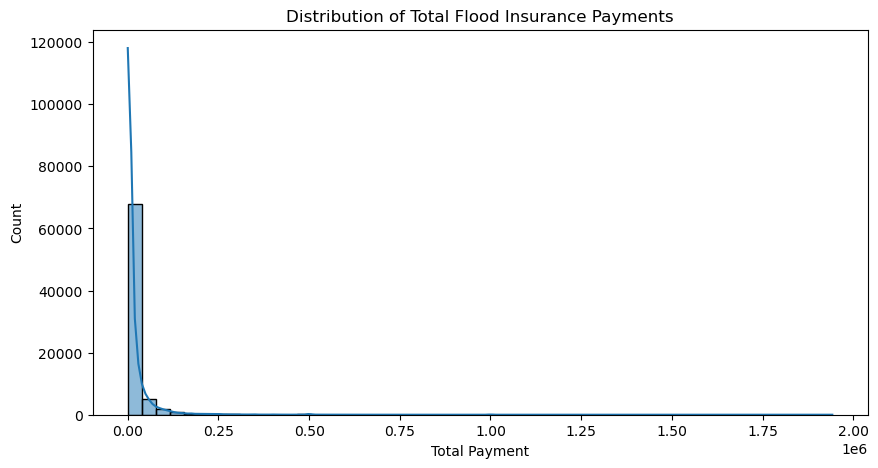

In [99]:
# What does the spread of total payment look like?

plt.figure(figsize = (10, 5))
sns.histplot(nfip['total_payment'], bins = 50, kde = True)
plt.xlabel('Total Payment')
plt.ylabel('Count')
plt.title('Distribution of Total Flood Insurance Payments')
plt.show();

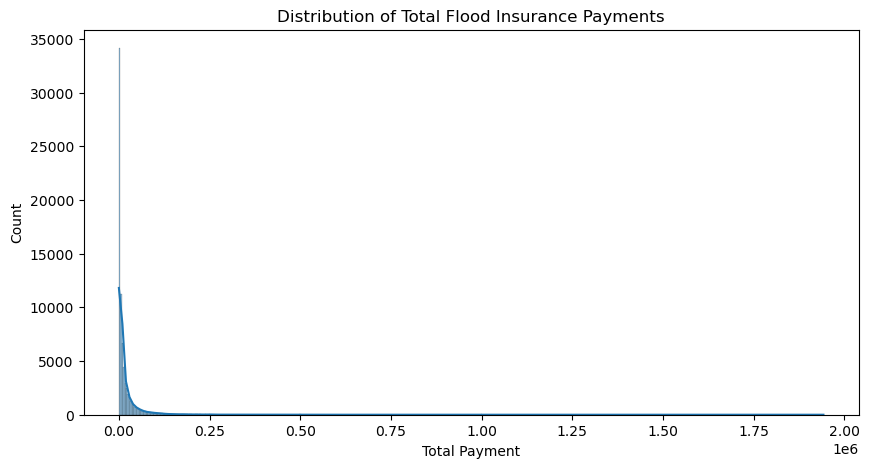

In [101]:
# Hm. That's extraordinarily unhelpful. Histograms can be a real pain to figure out sometimes.
# But I'll try another permutation.

plt.figure(figsize = (10, 5))
sns.histplot(nfip['total_payment'], bins = 500, kde = True)
plt.xlabel('Total Payment')
plt.ylabel('Count')
plt.title('Distribution of Total Flood Insurance Payments')
plt.show();

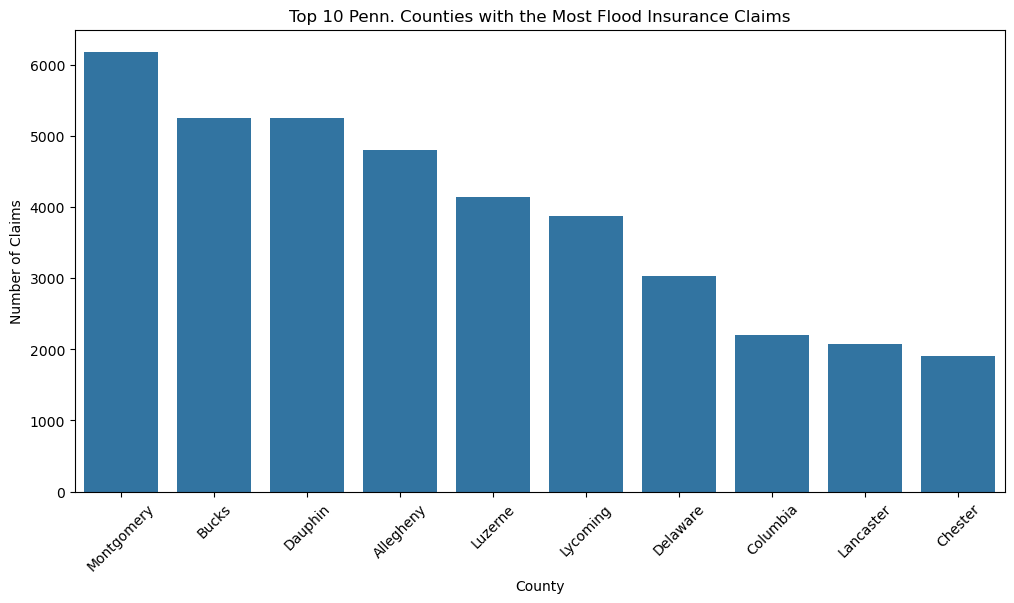

In [103]:
# Maybe we try a different variable!

plt.figure(figsize = (12, 6))
top_counties = nfip['county_name'].value_counts().head(10)
sns.barplot(x = top_counties.index, y=top_counties.values)
plt.xticks(rotation = 45)
plt.xlabel('County')
plt.ylabel('Number of Claims')
plt.title('Top 10 Penn. Counties with the Most Flood Insurance Claims')
plt.show();

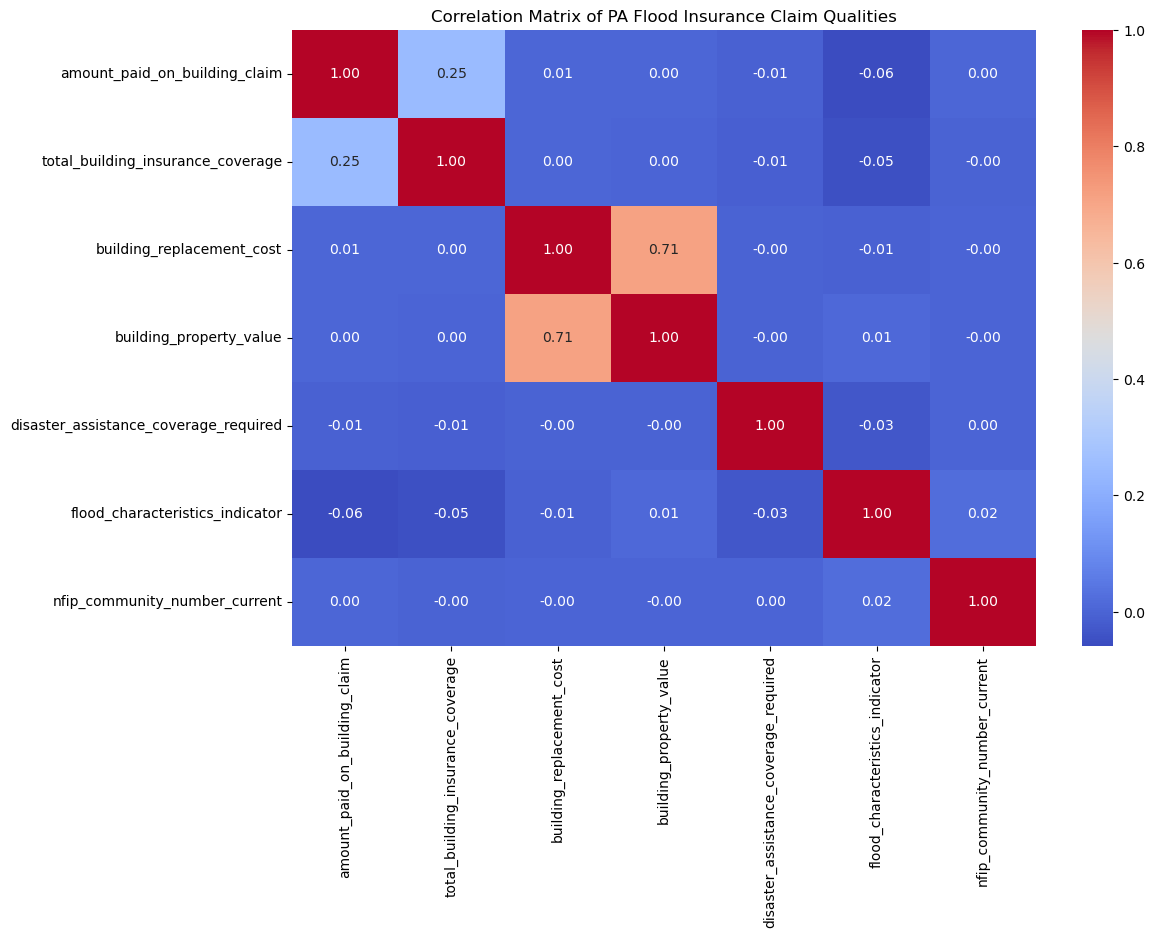

In [107]:
# Good old bar charts! Do I dare try a correlation matrix?

plt.figure(figsize = (12, 8)) # Let's make this guy a lil bigger than the last one
numerical_cols = ['amount_paid_on_building_claim', 'total_building_insurance_coverage', 'building_replacement_cost', 'building_property_value', 'disaster_assistance_coverage_required', 'flood_characteristics_indicator', 'nfip_community_number_current']
corr = nfip[numerical_cols].corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Matrix of PA Flood Insurance Claim Qualities')
plt.show();

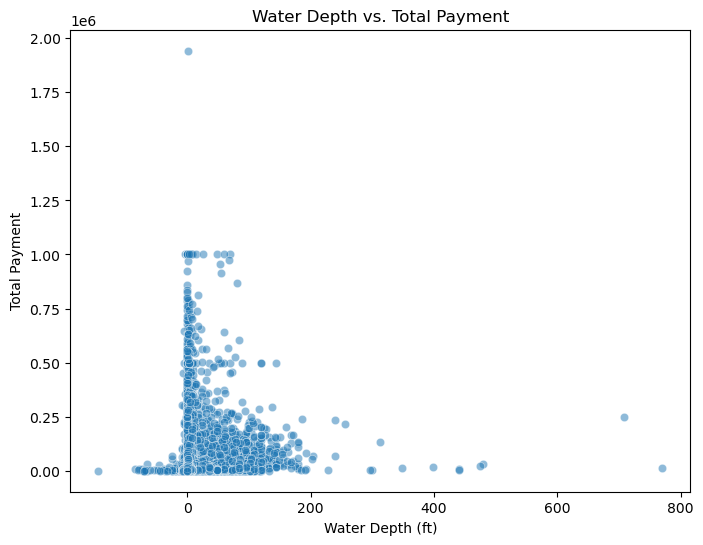

In [109]:
# Wow, that tells us almost nothing at all. There's only correlation where you'd expect it, like between property value and replacement cost.
# A scatterplot can be helpful when done right. Let's give it a go:

plt.figure(figsize = (8, 6))
sns.scatterplot(x = nfip['water_depth'], y = nfip['total_payment'], alpha = 0.5) # In theory we should see a positive correlation
plt.xlabel('Water Depth (ft)')
plt.ylabel('Total Payment')
plt.title('Water Depth vs. Total Payment')
plt.show();

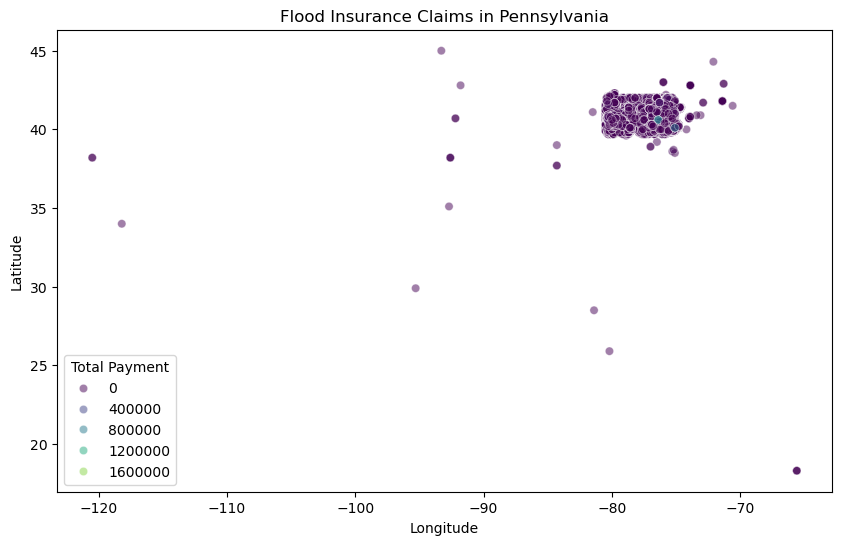

In [111]:
# Wow, okay, not really! But we have all those unhelpful data points of 0 water depth.
# It'll probably look a little more sensical when stuff like that is factored out.
# But I like to do that in Tableau; I find it more user-friendly to check.
# So let's move onto a geo-viz, maybe this will give us a taste of something:

plt.figure(figsize = (10, 6))
sns.scatterplot(x = nfip['longitude'], y=nfip['latitude'], hue=nfip['total_payment'], palette = 'viridis', alpha = 0.5) # I actually don't know how many claims have the lat/long, but since we're just fooling around with visualization tools, limited data may be our friend.
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Flood Insurance Claims in Pennsylvania')
plt.legend(title = "Total Payment")
plt.show();

C:\Users\natal\AppData\Local\Temp\ipykernel_6536\2113666532.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x = nfip['year_of_loss'], y = nfip['total_payment'], estimator = 'sum', ci = None)


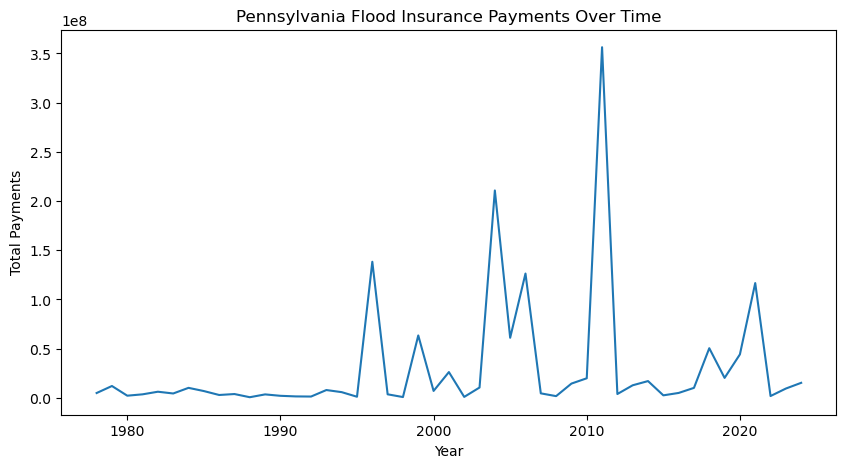

In [119]:
# Jeez, we've got some odd coordinates! For NFIP data I like to work with FIPS codes anyway, those tend to be more available than lat/long.

# OK this next one I'm very interested in; claims by year.

plt.figure(figsize = (10, 5))
sns.lineplot(x = nfip['year_of_loss'], y = nfip['total_payment'], estimator = 'sum', ci = None)
plt.xlabel('Year')
plt.ylabel('Total Payments')
plt.title('Pennsylvania Flood Insurance Payments Over Time')
plt.show();

In [121]:
# Very interesting! I see a peak around Sandy.